<a href="https://colab.research.google.com/github/jsebastianquiroga/Topicos_analitica_NLP/blob/main/Notebook/booksummaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  <td>
    <a target="_blank" href="https://github.com/jsebastianquiroga/Topicos_analitica_NLP"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /></a>
  </td>
  
</table>

# <img style="float: center; padding-right: 10px;" src="https://www.pikpng.com/pngl/b/467-4670553_universidad-javeriana-esslingen-am-neckar-clipart.png" width="100" height="150">



<h1> <strong>Tópicos avanzados en analítica - NLP.</strong></h1> 
<h2> Para: Jaime Andrés Vargas Cruz.</br></h2>
<h2>Integrantes:</br></h2>
<h2>Andres Guillermo Molano.</br></h2>
<h2>Juan Sebastián Quiroga Bernal. </h2>
<h2>Leonardo H. García.</br></h2>

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May  2 13:29:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import pandas as pd
import os
import re
import csv
import json
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from collections import Counter


# Conexion a gdrive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth

from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Booksummaries_share = '1xU2UNslewl5MOZbXSff6XEjA_odaX6rv' 
download = drive.CreateFile({'id': Booksummaries_share}) 
download.GetContentFile('booksummaries.txt')


df_book_summaries = pd.read_csv("booksummaries.txt", header=None, sep="\t", names=['Wiki_ID', 'Freebase_ID', 'Title', 'Author', 'Pub_date', 'Genres', 'Summary'])

df_book_summaries

,Wiki_ID,Freebase_ID,Title,Author,Pub_date,Genres,Summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
...,...,...,...,...,...,...,...
16554,36934824,/m/0m0p0hr,Under Wildwood,Colin Meloy,2012-09-25,NaN,"Prue McKeel, having rescued her brother from ..."
16555,37054020,/m/04f1nbs,Transfer of Power,Vince Flynn,2000-06-01,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...
16556,37122323,/m/0n5236t,Decoded,Jay-Z,2010-11-16,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...
16557,37132319,/m/0n4bqb1,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,2012-10-02,NaN,Colbert addresses topics including Wall Stree...


In [5]:
# Mostrar información sobre el DataFrame
df_book_summaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Wiki_ID      16559 non-null  int64 
 1   Freebase_ID  16559 non-null  object
 2   Title        16559 non-null  object
 3   Author       14177 non-null  object
 4   Pub_date     10949 non-null  object
 5   Genres       12841 non-null  object
 6   Summary      16559 non-null  object
dtypes: int64(1), object(6)
memory usage: 905.7+ KB


Se puede identificar desde la perspectiva de procesamiento de lenguaje natural, las variables como el titulo, genero y summary podria traer información en cada una de sus corporas que nos ayuden a 

In [ ]:
# Crear un DataFrame con el número de valores faltantes en cada columna
missing_values_df = pd.DataFrame(df_book_summaries.isna().sum(), columns=['recuento_faltantes'])

# Crear un gráfico de barras del recuento de valores faltantes utilizando Plotly
fig = px.bar(missing_values_df, x=missing_values_df.index, y='recuento_faltantes', 
             title='Valores faltantes en la base de datos')

# Personalizar el diseño del gráfico
fig.update_layout(xaxis_title='Columnas', yaxis_title='Recuento de valores faltantes', title_x=0.5)

# Mostrar el gráfico
fig.show()

In [ ]:
# Importar el módulo json
import json

# Definir función para extraer el primer género de una lista JSON
def parse_genres(genre_str):
    try:
        # Convertir la cadena JSON a una lista de valores
        genre_list = list(json.loads(genre_str).values())

        # Devolver el primer valor de la lista (el texto que quieres)
        return genre_list[0] if genre_list else ''
    except (TypeError, json.JSONDecodeError):
        return ''

# Aplicar la función parse_genres a la columna 'Genres'
df_book_summaries['Genres'] = df_book_summaries['Genres'].map(parse_genres)

# Mostrar las primeras 5 filas del DataFrame
df_book_summaries.head(5)

,Wiki_ID,Freebase_ID,Title,Author,Pub_date,Genres,Summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,Roman à clef,"Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,Science Fiction,"Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,Existentialism,The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,Hard science fiction,The novel posits that space around the Milky ...


In [ ]:
# Encontrar los autores más comunes
author_counts = df_book_summaries['Author'].value_counts().reset_index()
author_counts.columns = ['Autor', 'Recuento']

# Seleccionar los 10 principales autores con la cuenta más alta
top_authors = author_counts.nlargest(columns=["Recuento"], n=10)

# Restablecer el índice del DataFrame top_authors
top_authors.reset_index(drop=True, inplace=True)

# Ordenar los autores por Recuento
top_authors = top_authors.sort_values(by='Recuento', ascending=True)

# Crear un gráfico de barras de los recuentos de autor utilizando Plotly
fig = px.bar(top_authors, x='Recuento', y='Autor', 
             height=600, width=800, title='Autores más comunes')

# Personalizar el diseño del gráfico
fig.update_layout(xaxis_title='Recuento', yaxis_title='Autor', 
                  title_x=0.5, title_font_size=24)

# Mostrar el gráfico
fig.show()

# Calcular el porcentaje de libros con un autor asociado
total_books = len(df_book_summaries)
books_with_author = df_book_summaries['Author'].notna().sum()
percentage_books_with_author = (books_with_author / total_books) * 100

# # Imprimir los resultados
# print("Autores más comunes:")
# print(author_counts.head(10))
print(f"\nPorcentaje de libros con un autor asociado: {percentage_books_with_author:.2f}%")


Porcentaje de libros con un autor asociado: 85.62%


In [ ]:
# Convertir la columna 'Pub_date' al formato datetime
df_book_summaries['date'] = pd.to_datetime(df_book_summaries['Pub_date'], errors='coerce') #posible pedirda de información 

# Encontrar el periodo de tiempo cubierto por los libros analizados
earliest_date = df_book_summaries['date'].min()
latest_date = df_book_summaries['date'].max()

# Encontrar los libros más recientes y antiguos
most_recent_book = df_book_summaries.loc[df_book_summaries['date'].idxmax()]
oldest_book = df_book_summaries.loc[df_book_summaries['date'].idxmin()]

# Imprimir los resultados
print(f"Periodo de tiempo cubierto: {earliest_date} a {latest_date}")
print(f"Libro más reciente: {most_recent_book['Title']} (publicado el: {most_recent_book['date']})")
print(f"Libro más antiguo: {oldest_book['Title']} (publicado el: {oldest_book['date']})")

Periodo de tiempo cubierto: 1678-02-01 00:00:00 a 2013-01-01 00:00:00
Libro más reciente: Dr. Sleep (publicado el: 2013-01-01 00:00:00)
Libro más antiguo: The Pilgrim's Progress (publicado el: 1678-02-01 00:00:00)


In [ ]:
# Encontrar el índice de los títulos más largos y más cortos
longest_title_index = df_book_summaries['Title'].apply(len).idxmax()
shortest_title_index = df_book_summaries['Title'].apply(len).idxmin()

# Obtener los títulos más largos y más cortos
longest_title = df_book_summaries.loc[longest_title_index, 'Title']
shortest_title = df_book_summaries.loc[shortest_title_index, 'Title']

# Imprimir los resultados
print(f"Título más largo: {longest_title} (longitud: {len(longest_title)})")
print(f"Título más corto: {shortest_title} (longitud: {len(shortest_title)})")

Título más largo: Passionate Minds: The Great Love Affair of the Enlightenment, Featuring the Scientist Emilie du Chatelet, the Poet Voltaire, Sword Fights, Book Burnings, Assorted Kings, Seditious Verse, and the Birth of the Modern World (longitud: 220)
Título más corto: Q (longitud: 1)


In [ ]:
df_book_summaries['Genres'].astype(str)

0                Roman à clef
1             Science Fiction
2              Existentialism
3                            
4        Hard science fiction
                 ...         
16554                        
16555                Thriller
16556           Autobiography
16557                        
16558        Epistolary novel
Name: Genres, Length: 16559, dtype: object

In [ ]:
df_book_summaries

,Wiki_ID,Freebase_ID,Title,Author,Pub_date,Genres,Summary,date
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,Roman à clef,"Old Major, the old boar on the Manor Farm, ca...",1945-08-17
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,Science Fiction,"Alex, a teenager living in near-future Englan...",1962-01-01
2,986,/m/0ldx,The Plague,Albert Camus,1947,Existentialism,The text of The Plague is divided into five p...,1947-01-01
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,,The argument of the Enquiry proceeds by a ser...,NaT
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,Hard science fiction,The novel posits that space around the Milky ...,NaT
...,...,...,...,...,...,...,...,...
16554,36934824,/m/0m0p0hr,Under Wildwood,Colin Meloy,2012-09-25,,"Prue McKeel, having rescued her brother from ...",2012-09-25
16555,37054020,/m/04f1nbs,Transfer of Power,Vince Flynn,2000-06-01,Thriller,The reader first meets Rapp while he is doing...,2000-06-01
16556,37122323,/m/0n5236t,Decoded,Jay-Z,2010-11-16,Autobiography,The book follows very rough chronological ord...,2010-11-16
16557,37132319,/m/0n4bqb1,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,2012-10-02,,Colbert addresses topics including Wall Stree...,2012-10-02


In [ ]:
# Contar los géneros individuales
genre_counts = Counter()
for genre_str in df_book_summaries['Genres']:
    genre_list = genre_str.split(", ")
    genre_counts.update(genre_list)

# Crear un DataFrame con las columnas 'Género' y 'Recuento'
genre_count_df = pd.DataFrame({"Género": list(genre_counts.keys()), "Recuento": list(genre_counts.values())})

# Seleccionar los 10 principales géneros con la cuenta más alta
top_genres = genre_count_df.nlargest(columns=["Recuento"], n=10)

# Restablecer el índice del DataFrame top_genres
top_genres.reset_index(drop=True, inplace=True)

# Ordenar los géneros por Recuento
top_genres = top_genres.sort_values(by='Recuento', ascending=True)

# Crear un gráfico de barras de los recuentos de género utilizando Plotly
fig = px.bar(top_genres, x='Recuento', y='Género', 
             title='Géneros más comunes', height=600, width=800)

# Personalizar el diseño del gráfico
fig.update_layout(xaxis_title='Recuento', yaxis_title='Género', 
                  title_x=0.5, title_font_size=24, 
                  uniformtext_minsize=12, uniformtext_mode='hide')

# Mostrar el gráfico
fig.show()

# Imprimir los recuentos de los 10 géneros principales utilizando el formato dado
for index, row in top_genres.iterrows():
    print(f"Género: {row['Género']} (recuento: {row['Recuento']})")


Género: Thriller (recuento: 568)
Género: Fantasy (recuento: 624)
Género: Crime Fiction (recuento: 672)
Género: Mystery (recuento: 734)
Género: Novel (recuento: 925)
Género: Fiction (recuento: 943)
Género: Children's literature (recuento: 1152)
Género: Speculative fiction (recuento: 1438)
Género: Science Fiction (recuento: 2551)
Género:  (recuento: 3718)


Se procedera a realizar un limpiado general de los datos buscando, mayusculas o algun patron extraño para que el proceso de procesamiento del lenguaje pueda ser mas efectivo.

In [ ]:
# se crearan dos data frames, el primero con los elementos como ID, fechas fueras de este procesamiento (esta ultima debera tratarse los valores faltantes.)
df_book_summaries = df_book_summaries.rename(columns={'Wiki_ID':'id','Freebase_ID':'freebase_id','Title':'title', 'Author':'author', 'Pub_date':'date', 'Genres':'genres', 'Summary':'summary'})
df_str = df_book_summaries[['title', 'author', 'genres', 'summary']]
df_ok = df_book_summaries[['id', 'freebase_id', 'date']]

In [ ]:
df_str

,title,author,genres,summary
0,Animal Farm,George Orwell,Roman à clef,"Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,Anthony Burgess,Science Fiction,"Alex, a teenager living in near-future Englan..."
2,The Plague,Albert Camus,Existentialism,The text of The Plague is divided into five p...
3,An Enquiry Concerning Human Understanding,David Hume,,The argument of the Enquiry proceeds by a ser...
4,A Fire Upon the Deep,Vernor Vinge,Hard science fiction,The novel posits that space around the Milky ...
...,...,...,...,...
16554,Under Wildwood,Colin Meloy,,"Prue McKeel, having rescued her brother from ..."
16555,Transfer of Power,Vince Flynn,Thriller,The reader first meets Rapp while he is doing...
16556,Decoded,Jay-Z,Autobiography,The book follows very rough chronological ord...
16557,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,,Colbert addresses topics including Wall Stree...


In [ ]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import re
from unidecode import unidecode
import spacy
import multiprocessing

# Cargar modelo de lenguaje Spacy
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    # Verificar si el valor es una cadena
    if isinstance(text, str):
        # Convertir a minúsculas
        text = text.lower()
        #remover puntuacion, numeros o algun valor no alfaberico por espacios
        text = re.sub(r"[^a-zA-Z\s]+", " ", text)
        # remover non-ASCII chars.
        text = re.sub('[^\x00-\x7F]+',' ', text)
        # Remove URLs
        text = re.sub('https?:\/\/.*[\r\n]*', ' ', text)
        # Remove special chars.
        text = re.sub('[?!+%{}:;.,"\'()\[\]_]', '',text)
        # Remove double spaces.
        text = re.sub('\s+',' ',text)
        return text
    else:
        # Si no es una cadena, retornar el valor original sin cambios
        return text


# Definir una lista de nombres de columnas a limpiar
cols_to_clean = df_str.columns

# Dividir el dataframe en varias secciones
num_processes = multiprocessing.cpu_count()
chunk_size = int(df_str.shape[0] / num_processes)
chunks = [df_str.iloc[i:i+chunk_size,:] for i in range(0, df_str.shape[0], chunk_size)]

# Crear una función que procesa cada sección del dataframe en paralelo
def process_chunk(chunk):
    for col in cols_to_clean:
        chunk[col + '_limpio'] = chunk[col].apply(clean_text)
    return chunk

# Procesar cada sección del dataframe en paralelo
with multiprocessing.Pool(processes=num_processes) as pool:
    result_chunks = pool.map(process_chunk, chunks)

# Unir los resultados de cada sección del dataframe
df_str_limpio = pd.concat(result_chunks)

df_str_limpio

,title,author,genres,summary,title_limpio,author_limpio,genres_limpio,summary_limpio
0,Animal Farm,George Orwell,Roman à clef,"Old Major, the old boar on the Manor Farm, ca...",animal farm,george orwell,roman clef,old major the old boar on the manor farm call...
1,A Clockwork Orange,Anthony Burgess,Science Fiction,"Alex, a teenager living in near-future Englan...",a clockwork orange,anthony burgess,science fiction,alex a teenager living in near future england...
2,The Plague,Albert Camus,Existentialism,The text of The Plague is divided into five p...,the plague,albert camus,existentialism,the text of the plague is divided into five p...
3,An Enquiry Concerning Human Understanding,David Hume,,The argument of the Enquiry proceeds by a ser...,an enquiry concerning human understanding,david hume,,the argument of the enquiry proceeds by a ser...
4,A Fire Upon the Deep,Vernor Vinge,Hard science fiction,The novel posits that space around the Milky ...,a fire upon the deep,vernor vinge,hard science fiction,the novel posits that space around the milky ...
...,...,...,...,...,...,...,...,...
16554,Under Wildwood,Colin Meloy,,"Prue McKeel, having rescued her brother from ...",under wildwood,colin meloy,,prue mckeel having rescued her brother from t...
16555,Transfer of Power,Vince Flynn,Thriller,The reader first meets Rapp while he is doing...,transfer of power,vince flynn,thriller,the reader first meets rapp while he is doing...
16556,Decoded,Jay-Z,Autobiography,The book follows very rough chronological ord...,decoded,jay z,autobiography,the book follows very rough chronological ord...
16557,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,,Colbert addresses topics including Wall Stree...,america again re becoming the greatness we nev...,stephen colbert,,colbert addresses topics including wall stree...


In [ ]:
df_str = df_str_limpio[['title_limpio', 'author_limpio', 'genres_limpio', 'summary_limpio']].copy()

# Función para contar palabras en una cadena
def count_words(text):
    words = text.split()
    return len(words)

df_str['summary_limpio_conteo'] = df_str['summary_limpio'].apply(count_words)
print('Numero promedio de palabras en el summary de un libro :',df_str['summary_limpio_conteo'].mean().round(1))
df_str.sort_values(by=['summary_limpio_conteo'], ascending=False).head(3)

Numero promedio de palabras en el summary de un libro : 436.5


,title_limpio,author_limpio,genres_limpio,summary_limpio,summary_limpio_conteo
12395,kushiel s mercy,jacqueline carey,speculative fiction,upon reaching the city of elua sidonie and im...,10531
518,the history of tom jones a foundling,henry fielding,fiction,the novel s events occupy eighteen books squi...,9161
14672,fire world,chris d lacey,fantasy,it opens on the planet co pern ica with couns...,8065


In [ ]:
# Función para obtener palabras únicas en una cadena
def unique_words(text):
    words = text.split()
    return set(words)

# Obtener palabras únicas en la columna
unique_word_set = set()
for text in df_str['summary_limpio']:
    unique_word_set.update(unique_words(text))

# Contar palabras únicas
unique_word_count = len(unique_word_set)
print("Número de palabras únicas:", unique_word_count)

Número de palabras únicas: 117854


In [ ]:
import nltk
import spacy
from nltk.corpus import stopwords

In [ ]:
# Descargar los recursos necesarios
nltk.download('stopwords')
nltk.download('punkt')
!python -m spacy download en_core_web_sm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2023-04-26 00:36:03.816063: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 35.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# Crear el conjunto de palabras vacías de NLTK
nltk_stopwords = set(stopwords.words('english'))

# Crear el objeto nlp de spaCy
nlp = spacy.load("en_core_web_sm")

# Crear una función para eliminar palabras vacías utilizando NLTK o spaCy
def remove_stopwords(text, library="nltk"):
    # Tokenizar el texto utilizando NLTK
    words = nltk.word_tokenize(text)

    if library == "nltk":
        # Filtrar las palabras que no sean palabras vacías de NLTK
        filtered_words = [word for word in words if not word in nltk_stopwords]
    elif library == "spacy":
        # Filtrar las palabras que no sean palabras vacías de spaCy
        filtered_words = [word for word in words if not nlp.vocab[word].is_stop]
    else:
        raise ValueError("Invalid library argument. Use 'nltk' or 'spacy'.")

    # Unir las palabras filtradas en una cadena de texto y retornarla
    return ' '.join(filtered_words)

df_str['summary_limpio_sp_nltk'] = df_str['summary_limpio'].apply(remove_stopwords)
df_str['summary_limpio_sp_spacy'] = df_str['summary_limpio'].apply(lambda text: remove_stopwords(text, library="spacy"))

df_str['summary_limpio_sp_nltk_conteo'] = df_str['summary_limpio_sp_nltk'].apply(count_words)
df_str['summary_limpio_sp_spacy_conteo'] = df_str['summary_limpio_sp_spacy'].apply(count_words)
print('Promedio de cantidad de palabras por obersvación nltk:', df_str['summary_limpio_sp_nltk_conteo'].mean().round(1))
print('Promedio de cantidad de palabras por obersvación spacy:', df_str['summary_limpio_sp_spacy_conteo'].mean().round(1))

df_str.sort_values(by=['summary_limpio_conteo'], ascending=False).head(3)

Promedio de cantidad de palabras por obersvación nltk: 233.5
Promedio de cantidad de palabras por obersvación spacy: 220.8


,title_limpio,author_limpio,genres_limpio,summary_limpio,summary_limpio_conteo,summary_limpio_sp_nltk,summary_limpio_sp_spacy,summary_limpio_sp_nltk_conteo,summary_limpio_sp_spacy_conteo
12395,kushiel s mercy,jacqueline carey,speculative fiction,upon reaching the city of elua sidonie and im...,10531,upon reaching city elua sidonie imriel find ma...,reaching city elua sidonie imriel find people ...,5117,4653
518,the history of tom jones a foundling,henry fielding,fiction,the novel s events occupy eighteen books squi...,9161,novel events occupy eighteen books squire allw...,novel s events occupy eighteen books squire al...,4591,4343
14672,fire world,chris d lacey,fantasy,it opens on the planet co pern ica with couns...,8065,opens planet co pern ica counsellor str mberg ...,opens planet co pern ica counsellor str mberg ...,3938,3518


Debemos crear listaas y comparar que se elimina en cada para argumentar

In [ ]:
# Obtener palabras únicas en la columna
unique_word_set = set()
for text in df_str['summary_limpio']:
    unique_word_set.update(unique_words(text))

# Contar palabras únicas
unique_word_count = len(unique_word_set)
print("Número de palabras únicas antes de stopwords:", unique_word_count)

# Obtener palabras únicas en la columna
unique_word_set = set()
for text in df_str['summary_limpio_sp_nltk']:
    unique_word_set.update(unique_words(text))

# Contar palabras únicas
unique_word_count = len(unique_word_set)
print("Número de palabras únicas NLTK:", unique_word_count)



# Obtener palabras únicas en la columna
unique_word_set = set()
for text in df_str['summary_limpio_sp_spacy']:
    unique_word_set.update(unique_words(text))

# Contar palabras únicas
unique_word_count = len(unique_word_set)
print("Número de palabras únicas SpaCy:", unique_word_count)

Número de palabras únicas antes de stopwords: 117854
Número de palabras únicas NLTK: 117698
Número de palabras únicas SpaCy: 117547


In [ ]:
import nltk
import spacy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Descargar los recursos necesarios
nltk.download('stopwords')
nltk.download('punkt')
# Crear el objeto nlp de spaCy
nlp = spacy.load("en_core_web_sm")

# Crear el objeto PorterStemmer de NLTK
stemmer = PorterStemmer()

# Función para realizar stemming y lematización en un texto
def stem_and_lemmatize(text, stem=True, lemmatize=True):
    # Tokenizar el texto utilizando NLTK
    words = nltk.word_tokenize(text)

    # Aplicar lematización si está habilitado
    if lemmatize:
        words = ' '.join(words)
        doc = nlp(words)
        words = [token.lemma_ for token in doc]

    # Aplicar stemming si está habilitado
    if stem:
        words = [stemmer.stem(word) for word in words]

    # Unir las palabras procesadas en una cadena de texto y retornarla
    return ' '.join(words)

# Aplicar stemming y lematización al texto
df_str['summary_lemma_stemmer'] = df_str['summary_limpio'].apply(lambda text: stem_and_lemmatize(text, stem=True, lemmatize=True))
df_str['summary_lemma'] = df_str['summary_limpio'].apply(lambda text: stem_and_lemmatize(text, stem=False, lemmatize=True))
df_str['summary_stemmer'] = df_str['summary_limpio'].apply(lambda text: stem_and_lemmatize(text, stem=True, lemmatize=False))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Obtener palabras únicas en la columna
unique_word_set = set()
for text in df_str['summary_lemma_stemmer']:
    unique_word_set.update(unique_words(text))

# Contar palabras únicas
unique_word_count = len(unique_word_set)
print("Número de palabras únicas stemming y lematización :", unique_word_count)

# Obtener palabras únicas en la columna
unique_word_set = set()
for text in df_str['summary_lemma']:
    unique_word_set.update(unique_words(text))

# Contar palabras únicas
unique_word_count = len(unique_word_set)
print("Número de palabras únicas lematización :", unique_word_count)



# Obtener palabras únicas en la columna
unique_word_set = set()
for text in df_str['summary_stemmer']:
    unique_word_set.update(unique_words(text))

# Contar palabras únicas
unique_word_count = len(unique_word_set)
print("Número de palabras únicas stemming :", unique_word_count)

Número de palabras únicas stemming y lematización : 86965
Número de palabras únicas lematización : 102448
Número de palabras únicas stemming : 87298


In [ ]:
df_str

,title_limpio,author_limpio,genres_limpio,summary_limpio,summary_limpio_conteo,summary_limpio_sp_nltk,summary_limpio_sp_spacy,summary_limpio_sp_nltk_conteo,summary_limpio_sp_spacy_conteo,summary_lemma_stemmer,summary_lemma,summary_stemmer
0,animal farm,george orwell,roman clef,old major the old boar on the manor farm call...,952,old major old boar manor farm calls animals fa...,old major old boar manor farm calls animals fa...,534,508,old major the old boar on the manor farm call ...,old major the old boar on the manor farm call ...,old major the old boar on the manor farm call ...
1,a clockwork orange,anthony burgess,science fiction,alex a teenager living in near future england...,1036,alex teenager living near future england leads...,alex teenager living near future england leads...,589,573,alex a teenag live in near futur england lead ...,alex a teenager live in near future england le...,alex a teenag live in near futur england lead ...
2,the plague,albert camus,existentialism,the text of the plague is divided into five p...,1130,text plague divided five parts town oran thous...,text plague divided parts town oran thousands ...,609,571,the text of the plagu be divid into five part ...,the text of the plague be divide into five par...,the text of the plagu is divid into five part ...
3,an enquiry concerning human understanding,david hume,,the argument of the enquiry proceeds by a ser...,2829,argument enquiry proceeds series incremental s...,argument enquiry proceeds series incremental s...,1429,1241,the argument of the enquiri proceed by a seri ...,the argument of the enquiry proceed by a serie...,the argument of the enquiri proce by a seri of...
4,a fire upon the deep,vernor vinge,hard science fiction,the novel posits that space around the milky ...,734,novel posits space around milky way divided co...,novel posits space milky way divided concentri...,431,416,the novel posit that space around the milki wa...,the novel posit that space around the milky wa...,the novel posit that space around the milki wa...
...,...,...,...,...,...,...,...,...,...,...,...,...
16554,under wildwood,colin meloy,,prue mckeel having rescued her brother from t...,154,prue mckeel rescued brother dowager governess ...,prue mckeel having rescued brother dowager gov...,85,83,prue mckeel have rescu her brother from the do...,prue mckeel having rescue her brother from the...,prue mckeel have rescu her brother from the do...
16555,transfer of power,vince flynn,thriller,the reader first meets rapp while he is doing...,213,reader first meets rapp covert operation iran ...,reader meets rapp covert operation iran discov...,115,105,the reader first meet rapp while he be do a co...,the reader first meet rapp while he be do a co...,the reader first meet rapp while he is do a co...
16556,decoded,jay z,autobiography,the book follows very rough chronological ord...,318,book follows rough chronological order switchi...,book follows rough chronological order switchi...,155,145,the book follow veri rough chronolog order whi...,the book follow very rough chronological order...,the book follow veri rough chronolog order whi...
16557,america again re becoming the greatness we nev...,stephen colbert,,colbert addresses topics including wall stree...,20,colbert addresses topics including wall street...,colbert addresses topics including wall street...,16,16,colbert address topic includ wall street campa...,colbert address topic include wall street camp...,colbert address topic includ wall street campa...


intentarlo embeding NLKT, 

## Modelo Naive-Bayes

In [6]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
import pandas as pd
import seaborn as sns
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

In [8]:
df = df_book_summaries.copy()

In [9]:
print(df['Genres'].head(10))

0    {"/m/016lj8": "Roman \u00e0 clef", "/m/06nbt":...
1    {"/m/06n90": "Science Fiction", "/m/0l67h": "N...
2    {"/m/02m4t": "Existentialism", "/m/02xlf": "Fi...
3                                                  NaN
4    {"/m/03lrw": "Hard science fiction", "/m/06n90...
5    {"/m/098tmk": "War novel", "/m/016lj8": "Roman...
6    {"/m/0dwly": "Children's literature", "/m/01hm...
7                                                  NaN
8    {"/m/06n90": "Science Fiction", "/m/014dfn": "...
9    {"/m/06n90": "Science Fiction", "/m/014dfn": "...
Name: Genres, dtype: object


In [10]:
def parse_genres(genre_str):
    try:
        return list(json.loads(genre_str).values())
    except (TypeError, json.JSONDecodeError):
        return []

# Aplicar la función parse_genres a la columna 'Genres'
df['Genres'] = df['Genres'].map(parse_genres)

# Mostrar las primeras 5 filas del DataFrame
df.head(5)

,Wiki_ID,Freebase_ID,Title,Author,Pub_date,Genres,Summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"[Roman à clef, Satire, Children's literature, ...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,[],The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"[Hard science fiction, Science Fiction, Specul...",The novel posits that space around the Milky ...


In [11]:
# Function to check if "Science Fiction" is in the genre list
def is_science_fiction(genre_list):
    return 1 if "Science Fiction" in genre_list else 0

# Create a new column 'is_science_fiction' with values 1 for Science Fiction genre and 0 for all others
df['is_science_fiction'] = df['Genres'].apply(is_science_fiction)

# Get the counts of 1s and 0s in the 'is_science_fiction' column
counts = df['is_science_fiction'].value_counts()

# Calculate the proportion of 1s and 0s
proportions = counts / len(df)

print(proportions)

0    0.82668
1    0.17332
Name: is_science_fiction, dtype: float64


In [42]:
# Get rid of periods and punctuation
df['cleaned_summary'] = df['Summary'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [43]:
# Turn all strings to lowercase
df['cleaned_summary'] = df['cleaned_summary'].apply(lambda x: x.lower())

In [14]:
# Text normalization and tf-idf
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['cleaned_summary'])
y = df['is_science_fiction']

In [15]:
# Perform partitioning into training, validation, and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [16]:
# Use Naive Bayes model for prediction and evaluate its performance
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [17]:
# Validate the model
y_val_pred = clf.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

Validation Accuracy: 0.830012077294686


In [18]:
# Test the model
y_test_pred = clf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

Test Accuracy: 0.8285024154589372


In [21]:
nb_cm = confusion_matrix(y_test, y_test_pred)

In [22]:
print("Classification Report Naive-Bayes:")
print(classification_report(y_test, y_test_pred))

Classification Report Naive-Bayes:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2740
           1       1.00      0.01      0.01       572

    accuracy                           0.83      3312
   macro avg       0.91      0.50      0.46      3312
weighted avg       0.86      0.83      0.75      3312



## Modelo Bert

In [36]:
!pip install transformers
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
import torch
import pandas as pd
from torch.optim import AdamW
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

In [38]:
# Turn all strings to lowercase
df['Summary'] = df['Summary'].apply(lambda x: x.lower())

In [39]:
print(df['Summary'].head())

0     old major, the old boar on the manor farm, ca...
1     alex, a teenager living in near-future englan...
2     the text of the plague is divided into five p...
3     the argument of the enquiry proceeds by a ser...
4     the novel posits that space around the milky ...
Name: Summary, dtype: object


In [16]:
# Prepare the data for the BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X = tokenizer(df['Summary'].tolist(), padding=True, truncation=True, return_tensors='pt')['input_ids']
y = torch.tensor(df['is_science_fiction'].tolist())

In [17]:
# Perform partitioning into training, validation, and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [40]:
# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [41]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [42]:
# Determine the device to use for the model (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
# Use the BERT model for prediction and evaluate its performance
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
model.to(device)
model.train()

for epoch in range(3):
    for i in range(0, len(X_train), 32):
        input_ids = X_train[i:i+32].to(device)
        attention_mask = torch.ones_like(input_ids).to(device)
        labels = torch.tensor(y_train[i:i+32].tolist()).to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [50]:
# Define the evaluation function
def evaluate_and_get_labels(model, data_loader, device):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for input_ids, labels in data_loader:
            input_ids = input_ids.to(device)
            attention_mask = torch.ones_like(input_ids).to(device)
            labels = labels.to(device)

            logits = model(input_ids, attention_mask=attention_mask).logits
            predictions = torch.argmax(logits, dim=1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predictions.cpu().numpy())

    return true_labels, predicted_labels

In [53]:
# Get true and predicted labels for the test set
true_labels, predicted_labels = evaluate_and_get_labels(model, test_loader, device)

In [55]:
# Calculate and print accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9136


In [56]:
# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes):
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, cmap="Blues", fmt='g', xticklabels=classes, yticklabels=classes, ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)
    plt.show()

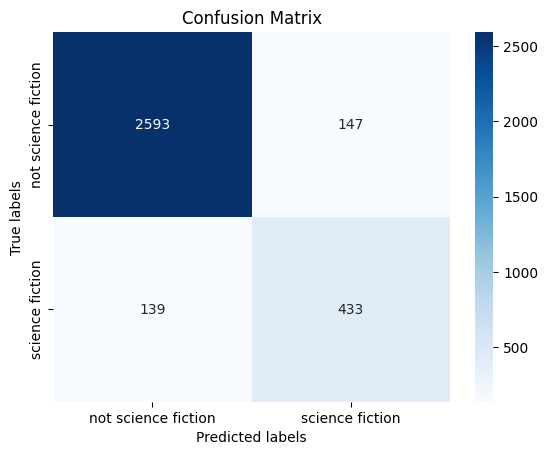

In [57]:
# Calculate and plot the confusion matrix
bert_cm = confusion_matrix(true_labels, predicted_labels)
plot_confusion_matrix(bert_cm, target_names)

In [54]:
# Print the classification report
target_names = ['not science fiction', 'science fiction']
print(classification_report(true_labels, predicted_labels, target_names=target_names))

                     precision    recall  f1-score   support

not science fiction       0.95      0.95      0.95      2740
    science fiction       0.75      0.76      0.75       572

           accuracy                           0.91      3312
          macro avg       0.85      0.85      0.85      3312
       weighted avg       0.91      0.91      0.91      3312

